# 01 — EDA: verify assumptions & visualize

This notebook loads `/data/raw/graduation_dataset.csv`, validates basic assumptions, and saves figures to `/figures`.
It also appends bullet points to `/reports/results.md`.

In [7]:
# --- Imports & setup
import os
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Plot style
sns.set(context="notebook", style="whitegrid")

# Paths (repo-root relative)
BASE = Path("..")
DATA_RAW = BASE / "data" / "raw" / "graduation_dataset.csv"
FIG_DIR = BASE / "figures"
REPORTS_MD = BASE / "reports" / "results.md"

FIG_DIR.mkdir(parents=True, exist_ok=True)



print(f'Loading: {DATA_RAW.resolve()}')

Loading: /home/glinux/Projects/Skole/AnvendtData/data/raw/graduation_dataset.csv


In [8]:
# --- Load
df = pd.read_csv(DATA_RAW)

print("Shape:", df.shape)
display(df.head(3))

Shape: (4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


In [9]:
# --- Structure & missingness
buf = []
buf.append("## df.info()")
from io import StringIO
info_io = StringIO()
df.info(buf=info_io)
buf.append(info_io.getvalue())

buf.append("\n## df.describe()")
buf.append(df.describe(include="all").to_string())

na_summary = df.isna().sum().sort_values(ascending=False)
buf.append("\n## Missing values per column")
buf.append(na_summary.to_string())

print("\n".join(buf))

## df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation         

Counts:
 Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Ratios:
 Target
Graduate    49.93%
Dropout     32.12%
Enrolled    17.95%
Name: proportion, dtype: object


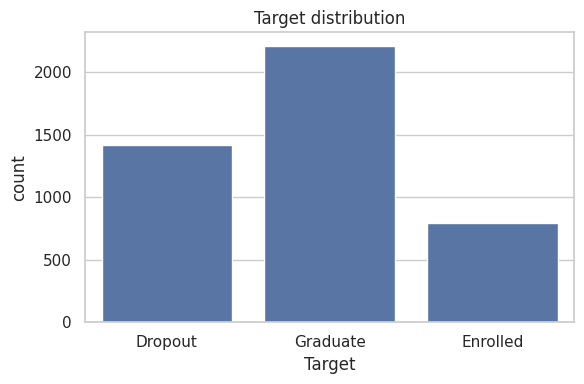

Saved: ../figures/eda_target.png


In [10]:
# --- Class balance (expects a column named 'Target')
if "Target" not in df.columns:
    raise KeyError("Expected a column named 'Target' (e.g., Dropout/Enrolled/Graduate).")

target_counts = df["Target"].value_counts(dropna=False)
target_ratio = df["Target"].value_counts(normalize=True, dropna=False)

print("Counts:\n", target_counts)
print("\nRatios:\n", (target_ratio*100).round(2).astype(str) + "%")

# Plot
plt.figure(figsize=(6,4))
ax = sns.countplot(x="Target", data=df)
plt.title("Target distribution")
plt.tight_layout()
fig_path = FIG_DIR / "eda_target.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print(f"Saved: {fig_path}")

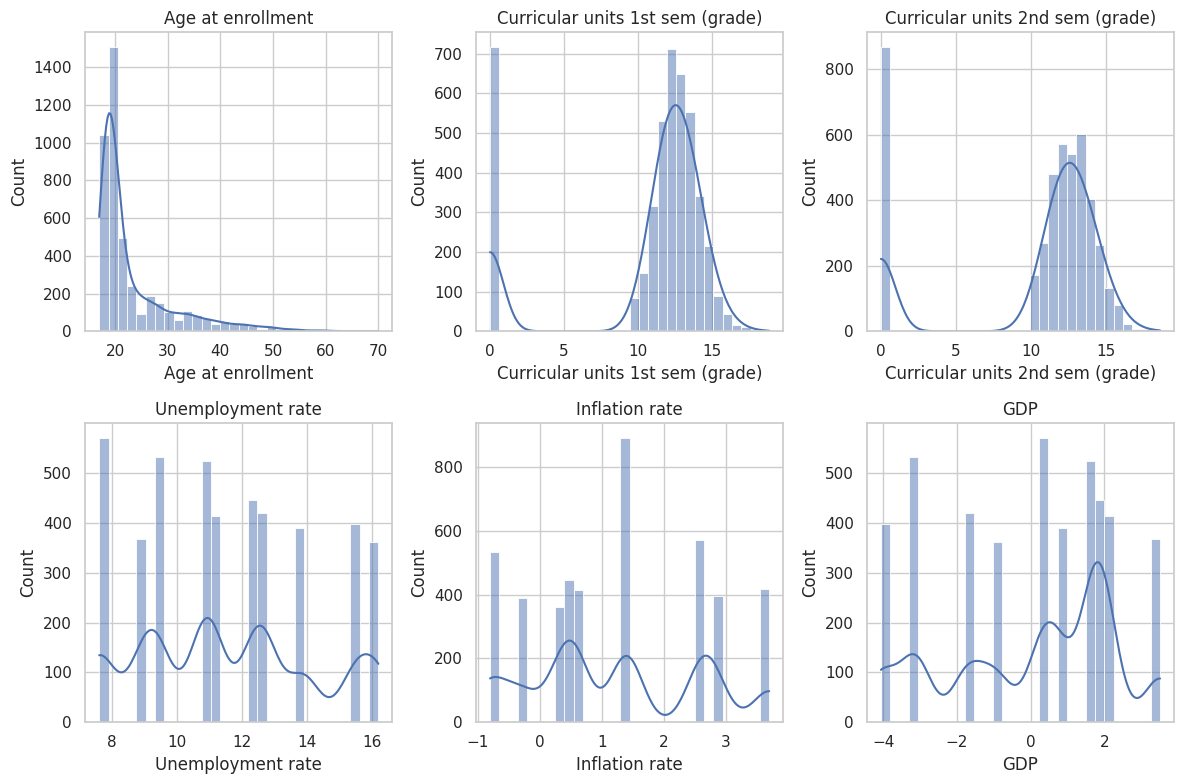

Saved: ../figures/eda_histograms.png
Continuous columns used for heatmap (20):
['Application mode', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']


In [11]:
# --- Numeric histograms
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Heuristic pick of "key continuous" if they exist (fall back to top N numerics)
preferred_keywords = ["grade", "gpa", "age", "gdp", "inflation", "unemployment"]
preferred_cols = [c for c in numeric_cols if any(k in c.lower() for k in preferred_keywords)]

cols_to_plot = preferred_cols if len(preferred_cols) >= 4 else numeric_cols[:8]
if not cols_to_plot:
    raise ValueError("No numeric columns found to plot histograms.")

n = len(cols_to_plot)
rows = math.ceil(n/3)
plt.figure(figsize=(12, 4*rows))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
fig_path = FIG_DIR / "eda_histograms.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print(f"Saved: {fig_path}")

# --- Choose continuous columns for correlation heatmap ---
import numpy as np
import pandas as pd

# 1) Start from numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 2) Try to drop the target if it's numeric-encoded
likely_target_names = ["Target", "target", "Status", "status", "Outcome", "outcome"]
for tcol in likely_target_names:
    if tcol in numeric_cols:
        numeric_cols.remove(tcol)

# 3) Remove near-constant/binary columns (0/1 etc.) — they clutter the heatmap
def is_binary_or_constant(s: pd.Series) -> bool:
    vals = pd.Series(s).dropna().unique()
    return len(vals) <= 2 or np.isclose(pd.Series(s).std(ddof=0), 0.0)

candidate_cols = []
for c in numeric_cols:
    s = df[c]
    # require at least some spread; also avoid id-like columns by checking unique count
    nunq = s.nunique(dropna=True)
    if nunq > 10 and not is_binary_or_constant(s):
        candidate_cols.append(c)

# 4) If nothing passes, fall back to all numeric (minus target)
continuous_cols = candidate_cols if len(candidate_cols) > 0 else numeric_cols

# 5) Optional: if there are too many columns, take top-k by variance to make the plot readable
MAX_COLS = 35
if len(continuous_cols) > MAX_COLS:
    variances = df[continuous_cols].var().sort_values(ascending=False)
    continuous_cols = variances.index[:MAX_COLS].tolist()

print(f"Continuous columns used for heatmap ({len(continuous_cols)}):")
print(continuous_cols)


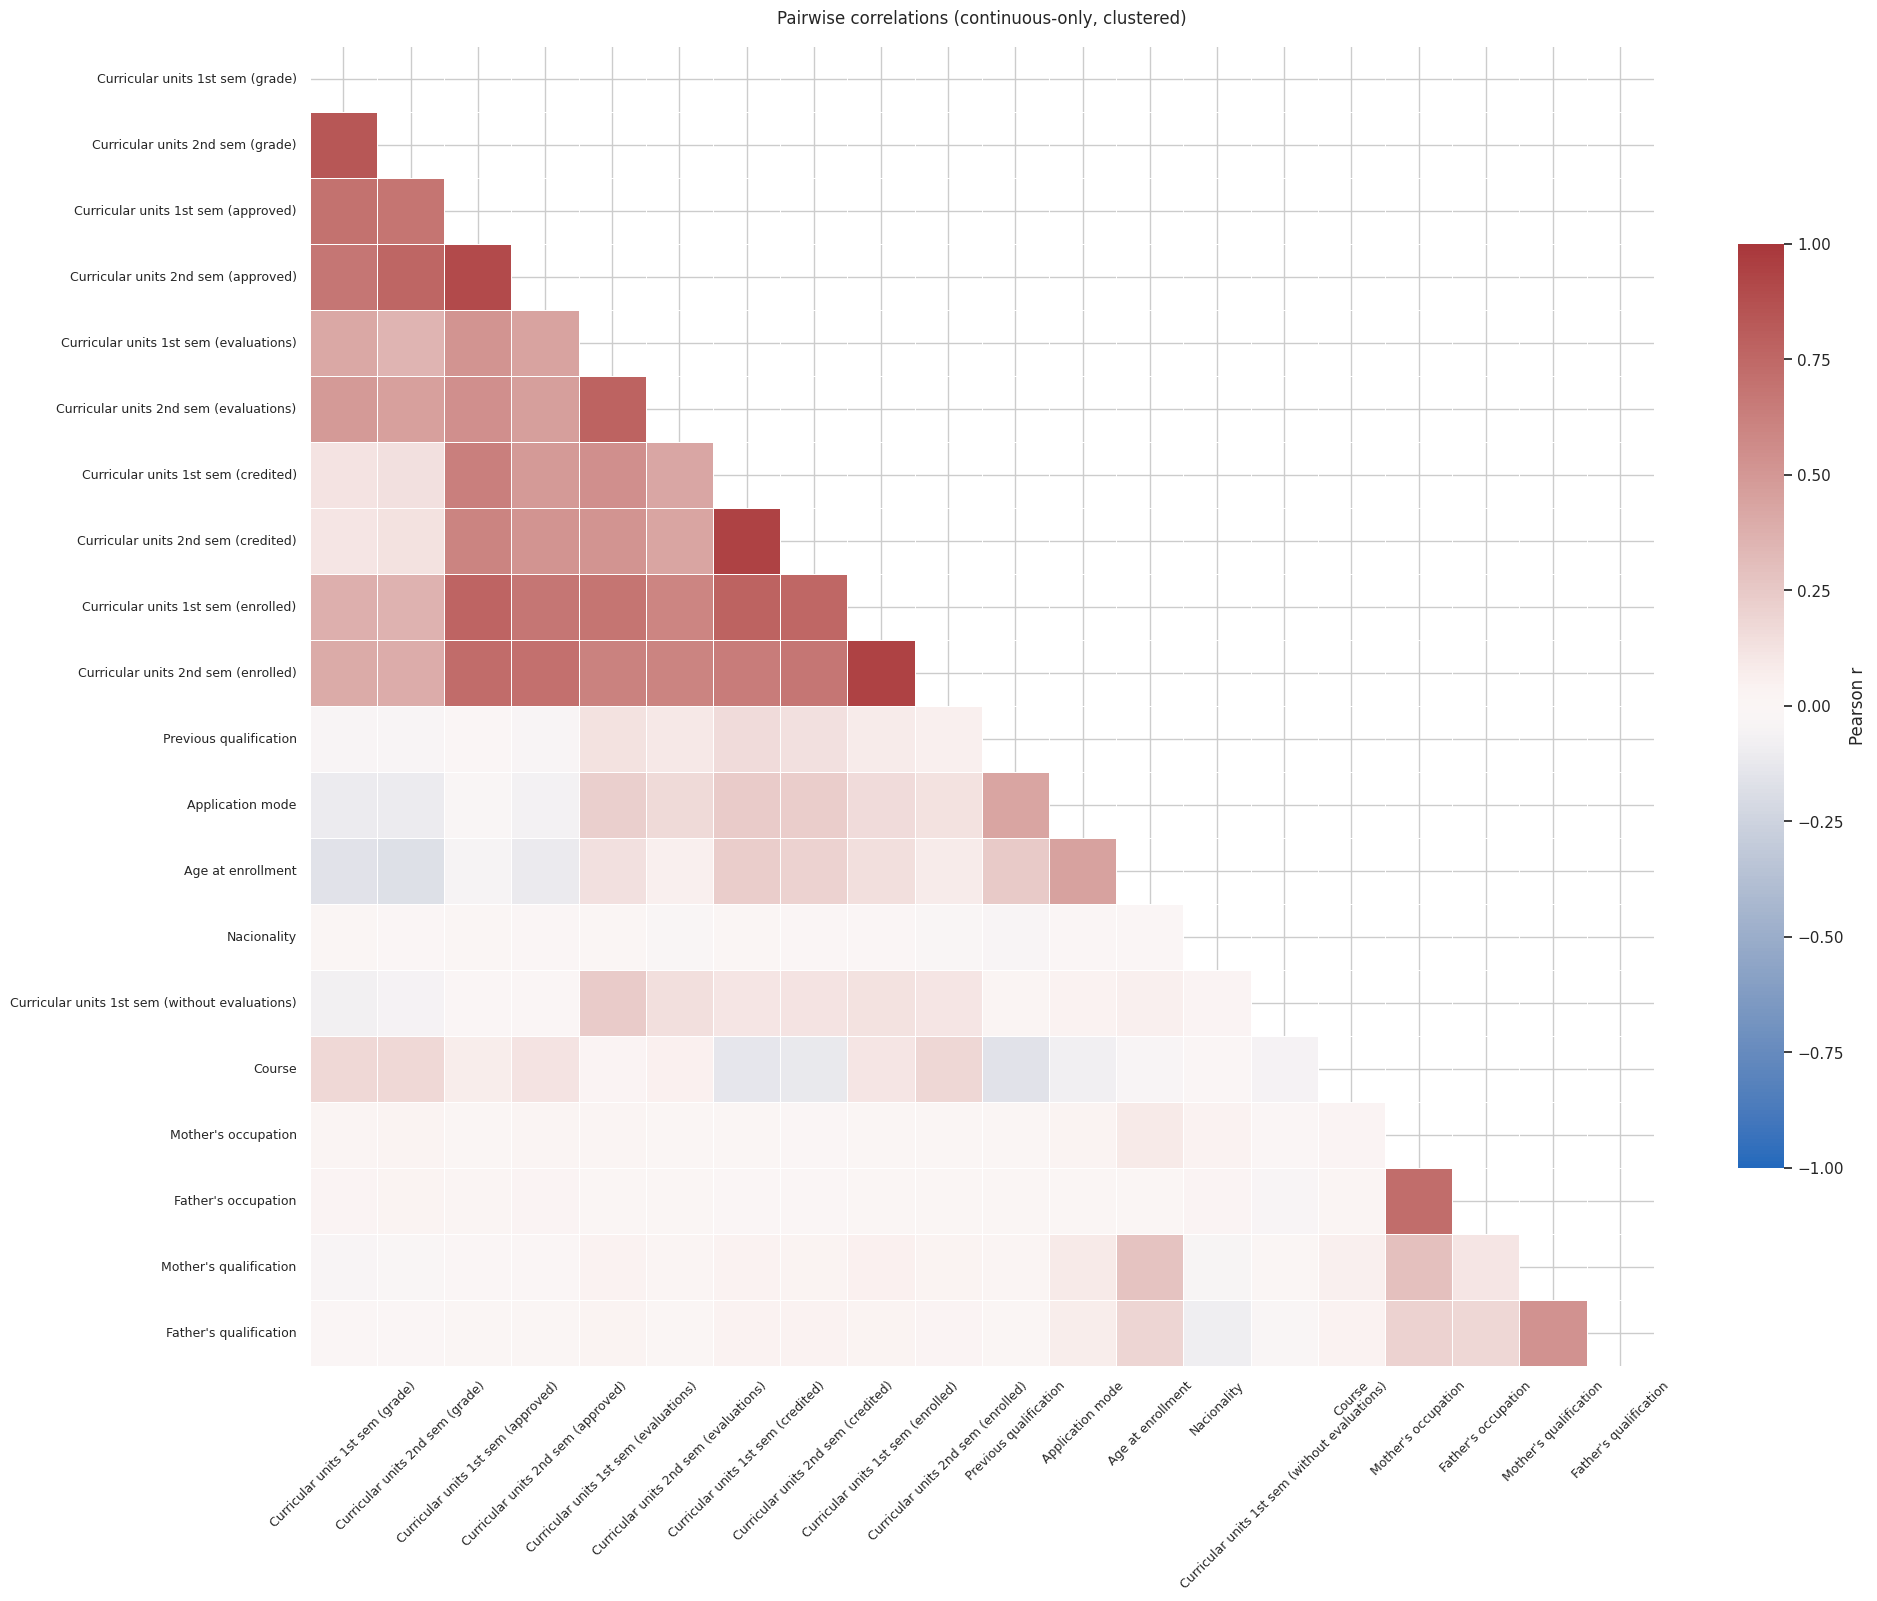

Saved: ../figures/eda_corr_heatmap.png


In [12]:
# --- Correlation heatmap (continuous-only, clustered, tidy labels)

corr = df[continuous_cols].corr(numeric_only=True)

# Cluster to find ordering
cg = sns.clustermap(
    corr, cmap="vlag", vmin=-1, vmax=1, center=0,
    method="average", metric="euclidean",
    row_cluster=True, col_cluster=True,
    figsize=(10, 10),
    cbar_kws={"label": "Pearson r"},
    dendrogram_ratio=0.05,
)
order = cg.dendrogram_row.reordered_ind
plt.close(cg.fig)
corr = corr.iloc[order, order]

# Proper plotting
fig, ax = plt.subplots(figsize=(1.0*len(corr.columns)+4, 1.0*len(corr.columns)+4))
mask = np.triu(np.ones_like(corr, dtype=bool))
annotate = corr.shape[0] <= 15

sns.heatmap(
    corr, mask=mask, cmap="vlag",
    vmin=-1, vmax=1, center=0,
    square=False,              # <--- important fix: let aspect adjust naturally
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.7, "label": "Pearson r"},
    annot=annotate, fmt=".2f" if annotate else "",
    annot_kws={"size": 8} if annotate else None,
    ax=ax,
)

ax.set_title("Pairwise correlations (continuous-only, clustered)", pad=16)
ax.tick_params(axis="x", rotation=45, labelsize=9)
ax.tick_params(axis="y", rotation=0, labelsize=9)

# Make room for long labels without them overlapping cells
plt.subplots_adjust(bottom=0.35, left=0.25, right=0.95, top=0.9)

fig_path = FIG_DIR / "eda_corr_heatmap.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {fig_path}")


In [13]:
# --- Generate bullets for results.md (robust)
from datetime import datetime

total_rows = len(df)
missing_total = int(df.isna().sum().sum())
no_missing = missing_total == 0

# Ensure target_ratio exists (in case you didn't run the class-balance cell)
if "target_ratio" not in globals():
    if "Target" in df.columns:
        target_ratio = df["Target"].value_counts(normalize=True, dropna=False)
    else:
        target_ratio = None  # no Target available

# Build class balance string
if target_ratio is not None:
    ratio_pct = (target_ratio * 100).round(1)
    ratio_str = ", ".join([f"{cls}: {pct}%" for cls, pct in ratio_pct.to_dict().items()])
else:
    ratio_str = "N/A"

# Skewness check on numeric columns (guard if none)
numeric_cols = df.select_dtypes(include="number").columns.tolist()
if len(numeric_cols) > 0:
    skews = df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
    right_skewed = [c for c, s in skews.items() if pd.notna(s) and s >= 0.75]
    left_skewed  = [c for c, s in skews.items() if pd.notna(s) and s <= -0.75]
else:
    right_skewed, left_skewed = [], []

date_str = datetime.now().strftime("%Y-%m-%d %H:%M")

bullets = [
    f"- Rows: **{total_rows}**; Columns: **{df.shape[1]}**.",
    f"- Missing values: **{'none' if no_missing else f'{missing_total} total'}**.",
    f"- Class balance → {ratio_str}.",
]

if right_skewed:
    bullets.append(
        f"- Right-skewed numeric columns: {', '.join(right_skewed[:6])}" +
        ("…" if len(right_skewed) > 6 else "")
    )
if left_skewed:
    bullets.append(
        f"- Left-skewed numeric columns: {', '.join(left_skewed[:6])}" +
        ("…" if len(left_skewed) > 6 else "")
    )

# Write/append section to reports/results.md
header = f"## EDA (01_eda.ipynb) — {date_str}\n\n"
section = header + "\n".join(bullets) + "\n\n"

with open(REPORTS_MD, "a", encoding="utf-8") as f:
    f.write(section)

print("Appended bullets to", REPORTS_MD.resolve())
print(section)


Appended bullets to /home/glinux/Projects/Skole/AnvendtData/reports/results.md
## EDA (01_eda.ipynb) — 2025-11-04 19:50

- Rows: **4424**; Columns: **35**.
- Missing values: **none**.
- Class balance → Graduate: 49.9%, Dropout: 32.1%, Enrolled: 17.9%.
- Right-skewed numeric columns: Educational special needs, Curricular units 1st sem (without evaluations), Nacionality, Curricular units 2nd sem (without evaluations), International, Curricular units 2nd sem (credited)…
- Left-skewed numeric columns: Curricular units 2nd sem (grade), Curricular units 1st sem (grade), Tuition fees up to date, Daytime/evening attendance




In [14]:
# --- Summary of saved artifacts
print("Figures saved to:", FIG_DIR.resolve())
for p in sorted(FIG_DIR.glob("eda_*.png")):
    print(" -", p.name)

Figures saved to: /home/glinux/Projects/Skole/AnvendtData/figures
 - eda_corr_heatmap.png
 - eda_histograms.png
 - eda_target.png
